# Projections from predicted RTs to a different CM
After successfully training a model with `train_with_rdkit.ipynb`, predictions for new molecules can be obtained. However, note that `train_with_rdkit.ipynb` train a Deep Neural Network on the SMRT dataset only. Hence, the resulting model can only accurately predict RTs for a Chromatographic Method (CM) identical to the one employed to collect the SMRT dataset.

This notebook illustrates how to build a projection function able to map the predicted RTs to the RTs from a different CM. To build such a projection function, a set of known molecules whose RT has been measured is needed. We use the Pubchem ID to identify the molecules.

Let us assume that the experimental RTs from a given CM are stored as the `cmm.csv` which is available under the `notebook_data` folder.

In [16]:
import pandas as pd

experimental_data = pd.read_csv("notebooks_data/cmm.csv", dtype={'RT': 'float32', 'Pubchem': 'Int64'})
print(experimental_data.head())

          RT  Pubchem
0  29.100000     <NA>
1  45.580002     <NA>
2  53.200001     2371
3  20.870001     <NA>
4  24.860001     <NA>


Note that the identity of some molecules is known (probably pure standards added to the experiment) but not all the molecules are known. To try to identify them, we could try to use the RTs in conjunction with the m/z ratio (not shown in this notebook). The RTs can be compared with those stored in a large database of known molecules. However, as noted before, we first need to "translate" the experimental RTs to the RTs of the CM used to create the database. As an illustrative example, we shall use the predictions stored in the CEU Mass Mediator database, whose RTs are based on SMRT.

In [17]:
from cmmrt.projection.data import load_cmm_predictions

cmm = load_cmm_predictions()
# Predictions are in seconds! Let's transform them to minutes
cmm.rt_pred = cmm.rt_pred / 60
cmm.head()

,Pubchem,cmm_id,rt_pred
0,647,1.0,11.084912
1,1195,2.0,10.149420
2,5281976,3.0,9.760773
3,445995,4.0,13.251669
4,5280528,5.0,13.251669


We use 1) the known molecules as `train_data` to create the projection function...

In [18]:
# We make sure that the Pubchem column has the same type in both DataFrames
train_data = experimental_data.merge(cmm.astype({'Pubchem': 'Int64'}), on='Pubchem')
print(train_data.head())

          RT  Pubchem    cmm_id    rt_pred
0  53.200001     2371       NaN  20.237692
1  46.349998   227033       NaN  16.488165
2  21.299999     3405       NaN   9.884387
3  26.090000   496377       NaN  11.969571
4   5.900000    12025  124302.0   9.234078


... and 2) a pre-trained model to project the RTs. This model has been pre-trained on the PredRet dataset using meta-learning to incorporate useful inductive biases to it. We should not forget the direction of the projections which can be Predicted->Experimental ('p2e') or Experimental->Predicted ('e2p').

In [19]:
import torch
from cmmrt.projection.models.projector.loader import load_pretrained_projector_pipeline

projector = load_pretrained_projector_pipeline(direction="e2p")

# We can now fit the projector using train_data
projector = projector.fit(
    train_data.RT.to_numpy(),
    train_data.rt_pred.to_numpy()
)

We can now find the "SMRT RTs" of all molecules (and not only those with known Pubchems):

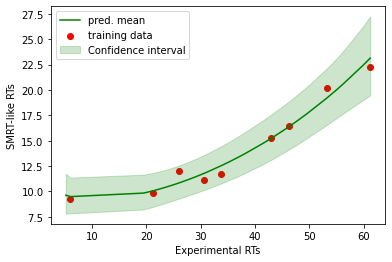

In [20]:
mean, lower_bound, upper_bound = projector.predict(experimental_data.RT.to_numpy())

# Let's visualize the predictions
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.scatter(train_data.RT, train_data.rt_pred, c='r', label='training data')
sorted_idx = np.argsort(experimental_data.RT.to_numpy().flatten())
plt.plot(experimental_data.RT.to_numpy()[sorted_idx], mean[sorted_idx], c='g', label='pred. mean')
plt.fill_between(experimental_data.RT.to_numpy()[sorted_idx],
                 lower_bound[sorted_idx],
                 upper_bound[sorted_idx],
                 color='g', label='Confidence interval', alpha=0.2)
plt.xlabel('Experimental RTs')
plt.ylabel('SMRT-like RTs')
plt.legend()
plt.show()

The predictions of SMRT-like RTs can now be saved in the experimental_data DataFrame for future use.

In [21]:
experimental_data['smrt_rts'] = mean
experimental_data.head()

,RT,Pubchem,smrt_rts
0,29.100000,<NA>,11.451269
1,45.580002,<NA>,16.139566
2,53.200001,2371,19.194006
3,20.870001,<NA>,10.015942
4,24.860001,<NA>,10.634629
